# Supervised Machine Learning: Regression and Classification

In [7]:

import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './work/machine_learning/01 - supervised_ml_regression_classification')
from lab_utils_uni import plt_intuition, plt_stationary, plt_update_onclick, soup_bowl

from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, unix_timestamp, col, regexp_replace
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
import pyspark.pandas as ps
from pyspark import StorageLevel

import numpy as np
import math

## Pyspark config

In [2]:
# SPAWN A SPARKSESSION
spark = SparkSession.\
        builder.\
        appName("pyspark-notebook").\
        master("spark://spark-master:7077").\
        config("spark.executor.cores", "12").\
        config("spark.executor.memory", "1024mb").\
        getOrCreate()

In [8]:
# Read dataset for this course and cache() it

df = ps.read_csv("hdfs://namenode:9000/data/cardio_base.csv", index_col="id")
df = df.astype(int)

df = ps.get_dummies(df, columns=['gender', 'smoke'], dtype='int', )

df = df.loc[df['ap_hi'] < 500]


# Why cache dataframe?
# Reusing Data: Caching is optimal when you need to perform multiple operations on the same dataset to 
#    avoid reading from storage repeatedly.
# Frequent Subset Access: Useful for frequently accessing small subsets of a large dataset, reducing the 
#    need to load the entire dataset repeatedly.

df_cached = df.spark.persist(StorageLevel.MEMORY_ONLY)

df_cached.head(10)

,age,height,weight,ap_hi,ap_lo,cholesterol,gender_1,gender_2,smoke_0,smoke_1
id,,,,,,,,,,
0,18393,168,62,110,80,1,0,1,1,0
1,20228,156,85,140,90,3,1,0,1,0
2,18857,165,64,130,70,3,1,0,1,0
3,17623,169,82,150,100,1,0,1,1,0
4,17474,156,56,100,60,1,1,0,1,0
8,21914,151,67,120,80,2,1,0,1,0
9,22113,157,93,130,80,3,1,0,1,0
12,22584,178,95,130,90,3,0,1,1,0
13,17668,158,71,110,70,1,1,0,1,0


In [9]:
from pyspark.sql.functions import unix_timestamp, col
df_cached.dtypes

age            int64
height         int64
weight         int64
ap_hi          int64
ap_lo          int64
cholesterol    int64
gender_1       int64
gender_2       int64
smoke_0        int64
smoke_1        int64
dtype: object

## Week 1

### Applications of Machine Learning

- Machine Learning learns from experience (Data)
- There are four types of machine learning categories:
    - **Supervised learning**
    - Unsupervised learning
    - Recommender system
    - Reinforcement learning



#### Supervised learning

##### **Univariate Linear regression**

![alt text](1.png)

The equation for univariate linear regression is
$$
\hat{y} = mx + b
$$

where:
- \( $ \hat{y} $ \) is the prediction
- \( x \) is the (single) feature
- Parameters
    - \( m \) is the slope of the line
    - \( b \) is the y-intercept of the line

![alt text](2.png)

$$J(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2 \tag{1}$$

This is the Mean-Squared Error cost function we try to minimize with linear regression. In summary, it measures the distance between predicted values and real values of y. It is one of the most common cost functions. Thus the objective is to:

$$\min J(w,b)$$

Gradient descent, a famous algorithm for minimizing cost functions based on tuning of parameters, can be used to solve linear regression. For example: $$ w = w - \alpha \cdot \frac{\partial J(w, b)}{\partial w} $$ $$ b = b - \alpha \cdot \frac{\partial J(w, b)}{\partial w} $$

where:

- ( w ) and ( b ) are the parameters of the model
- ( $ \alpha $ ) is the learning rate (step size)
- ( $ J(w, b) $ ) is the cost function

##### Implementation of Univariate Linear Regression in Spark using pyspark.pandas API

In [29]:
# LINEAR REGRESSION AGE AGE IN DAYS AND SYSTOLIC BLOOD PRESSURE
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

sampled_df = df_cached.sample(frac=0.1)

# Convert pandas dataframe to Spark dataframe
spark_df = sampled_df.to_spark()

# Create a vector assembler to combine the features into a single vector column
assembler = VectorAssembler(inputCols=["age"], outputCol="features")

# Transform the dataframe using the vector assembler
assembled_df = assembler.transform(spark_df)

# Split the data into a training and test set
train_ratio = 0.8
test_ratio = 1 - train_ratio

train_df, test_df = assembled_df.randomSplit([train_ratio, test_ratio], seed=42)

# Create a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="ap_hi")

# Fit the model to the data
lr_model = lr.fit(train_df)

print("Coefficients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))

pred = lr_model.transform(test_df)
pred.show(10)

# Create a RegressionEvaluator object
evaluator = RegressionEvaluator(labelCol="ap_hi", predictionCol="prediction")


# Calculate RMSE
rmse = evaluator.evaluate(pred, {evaluator.metricName: "rmse"})

# Calculate MSE
mse = evaluator.evaluate(pred, {evaluator.metricName: "mse"})

# Calculate MAE
mae = evaluator.evaluate(pred, {evaluator.metricName: "mae"})

# Calculate R2
r2 = evaluator.evaluate(pred, {evaluator.metricName: "r2"})

print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Coefficients: [0.0014148590043363144]
Intercept: 99.16021771958486
+-----+------+------+-----+-----+-----------+--------+--------+-------+-------+---------+------------------+
|  age|height|weight|ap_hi|ap_lo|cholesterol|gender_1|gender_2|smoke_0|smoke_1| features|        prediction|
+-----+------+------+-----+-----+-----------+--------+--------+-------+-------+---------+------------------+
|14314|   166|    64|  120|   80|          3|       0|       1|      1|      0|[14314.0]|119.41250950765487|
|14330|   150|    73|  120|   80|          1|       0|       1|      0|      1|[14330.0]|119.43514725172425|
|14336|   165|    61|   90|   60|          1|       1|       0|      1|      0|[14336.0]|119.44363640575027|
|14360|   152|    99|   90|   60|          1|       1|       0|      1|      0|[14360.0]|119.47759302185435|
|14370|   152|    72|  110|   70|          1|       1|       0|      1|      0|[14370.0]|119.49174161189771|
|14383|   155|    61|  110|   70|          2|       1|       

In [14]:
def compute_linear_function(x, w, b):
    """
    Computes the prediction of a linear model
    Args:
      x (ndarray (m,)): Data, m examples 
      w,b (scalar)    : model parameters  
    Returns
      y (ndarray (m,)): target values
    """
    m = x.shape[0]
    f_wb = np.zeros(m)
    for i in range(m):
        f_wb[i] = w * x[i] + b
        
    return f_wb

/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


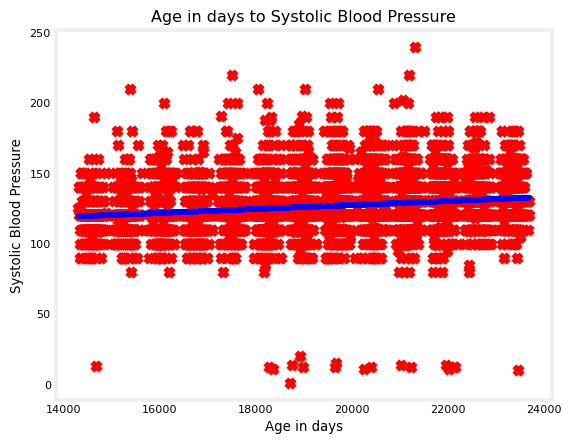

In [34]:
w = lr_model.coefficients[0]
b = lr_model.intercept

x_train = sampled_df[['age']].to_numpy()
y_train = sampled_df[['ap_hi']].to_numpy()

tmp_f_wb = compute_linear_function(x_train, w, b,)

plt.plot(x_train, tmp_f_wb, c='b',label='Our Prediction')
plt.scatter(x_train, y_train, marker='x', c='r')
# Set the title
plt.title("Age in days to Systolic Blood Pressure")
# Set the y-axis label
plt.ylabel('Systolic Blood Pressure')
# Set the x-axis label
plt.xlabel('Age in days')
plt.show()